<a href="https://colab.research.google.com/github/alexzendersen/pet_projects/blob/main/simpson_classifier/simspon_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexzendersen","key":"da07bef475e610f2931fb76179c3ffef"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                     title                                      size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                                Car Price Dataset                         135KB  2025-01-26 19:53:28          18086        297  1.0              
ak0212/indian-bike-sales-dataset                        Indian Bike Sales Dataset                 266KB  2025-02-21 12:20:27           1077         22  1.0              
samayashar/fraud-detection-transactions-dataset         Fraud Detection Transactions Dataset        2MB  2025-02-21 18:06:23           1169         24  1.0              
abdulmalik1518/mobiles-dataset-2025                     Mobiles Dataset (2025)                     20KB  2025-02-18 06:50:24           2531         50

In [ ]:
!kaggle competitions download -c journey-springfield

100% 519M/521M [00:26<00:00, 23.9MB/s]
100% 521M/521M [00:26<00:00, 20.6MB/s]


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

11.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip -q /content/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Feb 26 15:24:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.5),
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

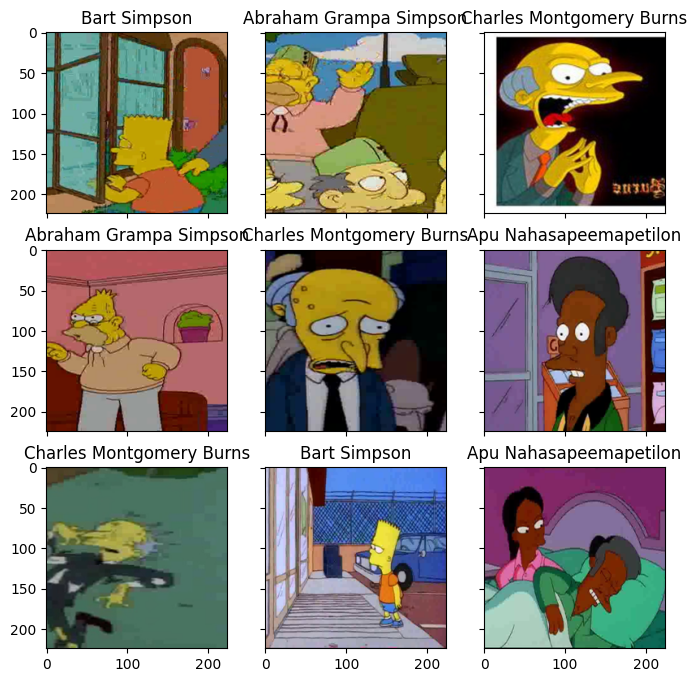

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # self.bottleneck = nn.Sequential(
        #     nn.Conv2d(in_channels = 64, out_channels = 16, kernel_size = 1),
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(),

        #     nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1),
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(),

        #     nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        # )


        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2, dilation=2),  # padding=2 для dilation=2
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(256, 48)
        self.out = nn.Linear(48, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # x  = self.bottleneck(x)
        # x = F.relu(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = nn.AdaptiveAvgPool2d(1)(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 8)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = 10e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            # print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
# print(simple_cnn)

we will classify :42


Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=100, batch_size=64)

epoch:   1%|          | 1/100 [01:59<3:16:48, 119.28s/it]


Epoch 001 train_loss: 2.7825     val_loss 2.6050 train_acc 0.2003 val_acc 0.2426


epoch:   2%|▏         | 2/100 [03:50<3:07:02, 114.52s/it]


Epoch 002 train_loss: 2.5878     val_loss 2.2175 train_acc 0.2579 val_acc 0.3538


epoch:   3%|▎         | 3/100 [05:41<3:02:49, 113.09s/it]


Epoch 003 train_loss: 1.9534     val_loss 1.7781 train_acc 0.4379 val_acc 0.4975


epoch:   4%|▍         | 4/100 [07:33<2:59:45, 112.34s/it]


Epoch 004 train_loss: 1.5249     val_loss 1.4113 train_acc 0.5678 val_acc 0.6060


epoch:   5%|▌         | 5/100 [09:24<2:57:17, 111.98s/it]


Epoch 005 train_loss: 1.1619     val_loss 1.0795 train_acc 0.6737 val_acc 0.6951


epoch:   6%|▌         | 6/100 [11:15<2:54:58, 111.69s/it]


Epoch 006 train_loss: 0.9446     val_loss 0.9527 train_acc 0.7362 val_acc 0.7381


epoch:   7%|▋         | 7/100 [13:06<2:52:59, 111.61s/it]


Epoch 007 train_loss: 0.7755     val_loss 0.8435 train_acc 0.7818 val_acc 0.7728


epoch:   8%|▊         | 8/100 [14:58<2:51:00, 111.52s/it]


Epoch 008 train_loss: 0.6723     val_loss 0.7407 train_acc 0.8132 val_acc 0.7986


epoch:   9%|▉         | 9/100 [16:49<2:48:53, 111.35s/it]


Epoch 009 train_loss: 0.5724     val_loss 0.7129 train_acc 0.8399 val_acc 0.8063


epoch:  10%|█         | 10/100 [18:40<2:46:52, 111.25s/it]


Epoch 010 train_loss: 0.4918     val_loss 0.6315 train_acc 0.8612 val_acc 0.8336


epoch:  11%|█         | 11/100 [20:31<2:45:03, 111.28s/it]


Epoch 011 train_loss: 0.4106     val_loss 0.5885 train_acc 0.8841 val_acc 0.8460


epoch:  12%|█▏        | 12/100 [22:22<2:43:08, 111.23s/it]


Epoch 012 train_loss: 0.3527     val_loss 0.5915 train_acc 0.9024 val_acc 0.8456


epoch:  13%|█▎        | 13/100 [24:13<2:41:16, 111.23s/it]


Epoch 013 train_loss: 0.3074     val_loss 0.5665 train_acc 0.9148 val_acc 0.8617


epoch:  14%|█▍        | 14/100 [26:05<2:39:22, 111.19s/it]


Epoch 014 train_loss: 0.2509     val_loss 0.6531 train_acc 0.9292 val_acc 0.8586


epoch:  15%|█▌        | 15/100 [27:56<2:37:29, 111.17s/it]


Epoch 015 train_loss: 0.2475     val_loss 0.5882 train_acc 0.9303 val_acc 0.8657


epoch:  16%|█▌        | 16/100 [29:47<2:35:41, 111.21s/it]


Epoch 016 train_loss: 0.2224     val_loss 0.6069 train_acc 0.9364 val_acc 0.8775


epoch:  17%|█▋        | 17/100 [31:38<2:33:49, 111.20s/it]


Epoch 017 train_loss: 0.1760     val_loss 0.6428 train_acc 0.9517 val_acc 0.8722


epoch:  18%|█▊        | 18/100 [33:29<2:31:51, 111.12s/it]


Epoch 018 train_loss: 0.1688     val_loss 0.6765 train_acc 0.9502 val_acc 0.8619


epoch:  19%|█▉        | 19/100 [35:20<2:29:56, 111.07s/it]


Epoch 019 train_loss: 0.1445     val_loss 0.6697 train_acc 0.9584 val_acc 0.8726


epoch:  20%|██        | 20/100 [37:11<2:28:12, 111.16s/it]


Epoch 020 train_loss: 0.1852     val_loss 0.5651 train_acc 0.9476 val_acc 0.8859


epoch:  21%|██        | 21/100 [39:03<2:26:19, 111.14s/it]


Epoch 021 train_loss: 0.1227     val_loss 0.6263 train_acc 0.9632 val_acc 0.8674


epoch:  22%|██▏       | 22/100 [40:54<2:24:25, 111.09s/it]


Epoch 022 train_loss: 0.0961     val_loss 0.7429 train_acc 0.9724 val_acc 0.8695


epoch:  23%|██▎       | 23/100 [42:45<2:22:33, 111.09s/it]


Epoch 023 train_loss: 0.0960     val_loss 0.6742 train_acc 0.9729 val_acc 0.8817


epoch:  24%|██▍       | 24/100 [44:36<2:20:45, 111.13s/it]


Epoch 024 train_loss: 0.0985     val_loss 0.7188 train_acc 0.9712 val_acc 0.8714


epoch:  25%|██▌       | 25/100 [46:27<2:18:53, 111.11s/it]


Epoch 025 train_loss: 0.1144     val_loss 0.6745 train_acc 0.9657 val_acc 0.8775


epoch:  26%|██▌       | 26/100 [48:18<2:16:54, 111.00s/it]


Epoch 026 train_loss: 0.0895     val_loss 0.6688 train_acc 0.9741 val_acc 0.8800


epoch:  27%|██▋       | 27/100 [50:09<2:15:00, 110.96s/it]


Epoch 027 train_loss: 0.1002     val_loss 0.6084 train_acc 0.9727 val_acc 0.8921


epoch:  28%|██▊       | 28/100 [51:59<2:13:08, 110.96s/it]


Epoch 028 train_loss: 0.0699     val_loss 0.6240 train_acc 0.9803 val_acc 0.8987


epoch:  29%|██▉       | 29/100 [53:50<2:11:19, 110.97s/it]


Epoch 029 train_loss: 0.0792     val_loss 0.6141 train_acc 0.9784 val_acc 0.8888


epoch:  30%|███       | 30/100 [55:41<2:09:23, 110.90s/it]


Epoch 030 train_loss: 0.0841     val_loss 0.7575 train_acc 0.9766 val_acc 0.8796


epoch:  31%|███       | 31/100 [57:32<2:07:30, 110.88s/it]


Epoch 031 train_loss: 0.0728     val_loss 0.7668 train_acc 0.9789 val_acc 0.8804


epoch:  32%|███▏      | 32/100 [59:23<2:05:39, 110.88s/it]


Epoch 032 train_loss: 0.0872     val_loss 0.6537 train_acc 0.9746 val_acc 0.8867


epoch:  33%|███▎      | 33/100 [1:01:13<2:03:42, 110.78s/it]


Epoch 033 train_loss: 0.0507     val_loss 0.7456 train_acc 0.9853 val_acc 0.8814


epoch:  34%|███▍      | 34/100 [1:03:04<2:01:45, 110.70s/it]


Epoch 034 train_loss: 0.0615     val_loss 0.7100 train_acc 0.9819 val_acc 0.8877


epoch:  35%|███▌      | 35/100 [1:04:55<1:59:55, 110.70s/it]


Epoch 035 train_loss: 0.0524     val_loss 0.7113 train_acc 0.9839 val_acc 0.8856


epoch:  36%|███▌      | 36/100 [1:06:45<1:57:59, 110.61s/it]


Epoch 036 train_loss: 0.0731     val_loss 0.7844 train_acc 0.9792 val_acc 0.8875


epoch:  37%|███▋      | 37/100 [1:08:36<1:56:07, 110.59s/it]


Epoch 037 train_loss: 0.0785     val_loss 0.7029 train_acc 0.9776 val_acc 0.8838


epoch:  38%|███▊      | 38/100 [1:10:26<1:54:14, 110.56s/it]


Epoch 038 train_loss: 0.0473     val_loss 0.7143 train_acc 0.9866 val_acc 0.8877


epoch:  39%|███▉      | 39/100 [1:12:17<1:52:21, 110.52s/it]


Epoch 039 train_loss: 0.0467     val_loss 0.7744 train_acc 0.9876 val_acc 0.8877


epoch:  40%|████      | 40/100 [1:14:07<1:50:31, 110.53s/it]


Epoch 040 train_loss: 0.0483     val_loss 0.7996 train_acc 0.9873 val_acc 0.8794


epoch:  41%|████      | 41/100 [1:15:58<1:48:40, 110.51s/it]


Epoch 041 train_loss: 0.0721     val_loss 0.8229 train_acc 0.9801 val_acc 0.8718


epoch:  42%|████▏     | 42/100 [1:17:48<1:46:51, 110.54s/it]


Epoch 042 train_loss: 0.0476     val_loss 0.7338 train_acc 0.9873 val_acc 0.8955


epoch:  43%|████▎     | 43/100 [1:19:39<1:45:00, 110.53s/it]


Epoch 043 train_loss: 0.0565     val_loss 0.6096 train_acc 0.9849 val_acc 0.9012


epoch:  44%|████▍     | 44/100 [1:21:29<1:43:04, 110.44s/it]


Epoch 044 train_loss: 0.0355     val_loss 0.7045 train_acc 0.9897 val_acc 0.8901


epoch:  45%|████▌     | 45/100 [1:23:19<1:41:14, 110.45s/it]


Epoch 045 train_loss: 0.0618     val_loss 0.6886 train_acc 0.9829 val_acc 0.9031


epoch:  46%|████▌     | 46/100 [1:25:10<1:39:23, 110.43s/it]


Epoch 046 train_loss: 0.0535     val_loss 0.6992 train_acc 0.9839 val_acc 0.8865


epoch:  47%|████▋     | 47/100 [1:27:00<1:37:30, 110.38s/it]


Epoch 047 train_loss: 0.0351     val_loss 0.7208 train_acc 0.9898 val_acc 0.9043


epoch:  48%|████▊     | 48/100 [1:28:50<1:35:38, 110.35s/it]


Epoch 048 train_loss: 0.0398     val_loss 0.7005 train_acc 0.9899 val_acc 0.8955


epoch:  49%|████▉     | 49/100 [1:30:41<1:33:46, 110.33s/it]


Epoch 049 train_loss: 0.0434     val_loss 0.9744 train_acc 0.9879 val_acc 0.8741


epoch:  50%|█████     | 50/100 [1:32:31<1:31:52, 110.25s/it]


Epoch 050 train_loss: 0.0727     val_loss 0.6107 train_acc 0.9801 val_acc 0.9039


epoch:  51%|█████     | 51/100 [1:34:21<1:30:01, 110.24s/it]


Epoch 051 train_loss: 0.0376     val_loss 0.7769 train_acc 0.9898 val_acc 0.8900


epoch:  52%|█████▏    | 52/100 [1:36:11<1:28:12, 110.27s/it]


Epoch 052 train_loss: 0.0323     val_loss 0.9803 train_acc 0.9918 val_acc 0.8689


epoch:  53%|█████▎    | 53/100 [1:38:01<1:26:19, 110.20s/it]


Epoch 053 train_loss: 0.0539     val_loss 0.7626 train_acc 0.9843 val_acc 0.8955


epoch:  54%|█████▍    | 54/100 [1:39:51<1:24:29, 110.21s/it]


Epoch 054 train_loss: 0.0354     val_loss 0.6238 train_acc 0.9905 val_acc 0.9028


epoch:  55%|█████▌    | 55/100 [1:41:42<1:22:39, 110.22s/it]


Epoch 055 train_loss: 0.0459     val_loss 0.6403 train_acc 0.9890 val_acc 0.9119


epoch:  56%|█████▌    | 56/100 [1:43:32<1:20:46, 110.15s/it]


Epoch 056 train_loss: 0.0125     val_loss 0.6646 train_acc 0.9965 val_acc 0.9123


epoch:  57%|█████▋    | 57/100 [1:45:22<1:18:55, 110.14s/it]


Epoch 057 train_loss: 0.0211     val_loss 0.9594 train_acc 0.9944 val_acc 0.8878


epoch:  58%|█████▊    | 58/100 [1:47:12<1:17:10, 110.24s/it]


Epoch 058 train_loss: 0.0748     val_loss 0.7730 train_acc 0.9796 val_acc 0.8892


epoch:  59%|█████▉    | 59/100 [1:49:02<1:15:18, 110.21s/it]


Epoch 059 train_loss: 0.0387     val_loss 0.8199 train_acc 0.9884 val_acc 0.8892


epoch:  60%|██████    | 60/100 [1:50:52<1:13:25, 110.14s/it]


Epoch 060 train_loss: 0.0271     val_loss 0.6498 train_acc 0.9924 val_acc 0.9079


epoch:  61%|██████    | 61/100 [1:52:42<1:11:34, 110.12s/it]


Epoch 061 train_loss: 0.0210     val_loss 0.8512 train_acc 0.9943 val_acc 0.9014


epoch:  62%|██████▏   | 62/100 [1:54:33<1:09:44, 110.12s/it]


Epoch 062 train_loss: 0.0769     val_loss 0.6645 train_acc 0.9783 val_acc 0.8997


epoch:  63%|██████▎   | 63/100 [1:56:22<1:07:50, 110.02s/it]


Epoch 063 train_loss: 0.0359     val_loss 0.6806 train_acc 0.9912 val_acc 0.8968


epoch:  64%|██████▍   | 64/100 [1:58:12<1:06:00, 110.01s/it]


Epoch 064 train_loss: 0.0236     val_loss 0.7442 train_acc 0.9937 val_acc 0.9060


epoch:  65%|██████▌   | 65/100 [2:00:02<1:04:08, 109.97s/it]


Epoch 065 train_loss: 0.0369     val_loss 0.6705 train_acc 0.9899 val_acc 0.9045


epoch:  66%|██████▌   | 66/100 [2:01:52<1:02:18, 109.96s/it]


Epoch 066 train_loss: 0.0204     val_loss 0.6408 train_acc 0.9943 val_acc 0.9112


epoch:  67%|██████▋   | 67/100 [2:03:42<1:00:31, 110.05s/it]


Epoch 067 train_loss: 0.0547     val_loss 0.7916 train_acc 0.9862 val_acc 0.8794


epoch:  68%|██████▊   | 68/100 [2:05:32<58:41, 110.03s/it]


Epoch 068 train_loss: 0.0537     val_loss 0.7380 train_acc 0.9855 val_acc 0.8953


epoch:  69%|██████▉   | 69/100 [2:07:23<56:52, 110.07s/it]


Epoch 069 train_loss: 0.0144     val_loss 0.7390 train_acc 0.9965 val_acc 0.9054


epoch:  70%|███████   | 70/100 [2:09:13<55:00, 110.03s/it]


Epoch 070 train_loss: 0.0025     val_loss 0.9154 train_acc 0.9992 val_acc 0.8943


epoch:  71%|███████   | 71/100 [2:11:02<53:09, 110.00s/it]


Epoch 071 train_loss: 0.0411     val_loss 0.8310 train_acc 0.9892 val_acc 0.8861


epoch:  72%|███████▏  | 72/100 [2:12:52<51:18, 109.94s/it]


Epoch 072 train_loss: 0.0564     val_loss 0.7547 train_acc 0.9843 val_acc 0.8921


epoch:  73%|███████▎  | 73/100 [2:14:42<49:27, 109.91s/it]


Epoch 073 train_loss: 0.0462     val_loss 0.6600 train_acc 0.9889 val_acc 0.9001


epoch:  74%|███████▍  | 74/100 [2:16:32<47:36, 109.88s/it]


Epoch 074 train_loss: 0.0229     val_loss 0.7267 train_acc 0.9938 val_acc 0.9052


epoch:  75%|███████▌  | 75/100 [2:18:22<45:47, 109.92s/it]


Epoch 075 train_loss: 0.0363     val_loss 0.8475 train_acc 0.9906 val_acc 0.8867


epoch:  76%|███████▌  | 76/100 [2:20:12<43:58, 109.92s/it]


Epoch 076 train_loss: 0.0548     val_loss 0.7953 train_acc 0.9862 val_acc 0.8802


epoch:  77%|███████▋  | 77/100 [2:22:02<42:06, 109.86s/it]


Epoch 077 train_loss: 0.0379     val_loss 0.6939 train_acc 0.9902 val_acc 0.9050


epoch:  78%|███████▊  | 78/100 [2:23:52<40:18, 109.91s/it]


Epoch 078 train_loss: 0.0151     val_loss 0.9225 train_acc 0.9965 val_acc 0.8915


epoch:  79%|███████▉  | 79/100 [2:25:41<38:26, 109.85s/it]


Epoch 079 train_loss: 0.0347     val_loss 0.7275 train_acc 0.9904 val_acc 0.9075


epoch:  80%|████████  | 80/100 [2:27:31<36:37, 109.88s/it]


Epoch 080 train_loss: 0.0138     val_loss 0.8154 train_acc 0.9959 val_acc 0.9052


epoch:  81%|████████  | 81/100 [2:29:21<34:46, 109.83s/it]


Epoch 081 train_loss: 0.0530     val_loss 0.7401 train_acc 0.9868 val_acc 0.8966


epoch:  82%|████████▏ | 82/100 [2:31:11<32:57, 109.84s/it]


Epoch 082 train_loss: 0.0293     val_loss 0.9030 train_acc 0.9925 val_acc 0.8833


epoch:  83%|████████▎ | 83/100 [2:33:01<31:07, 109.83s/it]


Epoch 083 train_loss: 0.0271     val_loss 0.8051 train_acc 0.9925 val_acc 0.9043


epoch:  84%|████████▍ | 84/100 [2:34:51<29:18, 109.88s/it]


Epoch 084 train_loss: 0.0060     val_loss 0.7493 train_acc 0.9982 val_acc 0.9113


epoch:  85%|████████▌ | 85/100 [2:36:41<27:28, 109.90s/it]


Epoch 085 train_loss: 0.0398     val_loss 0.8260 train_acc 0.9901 val_acc 0.8886


epoch:  86%|████████▌ | 86/100 [2:38:30<25:38, 109.90s/it]


Epoch 086 train_loss: 0.0560     val_loss 0.6252 train_acc 0.9874 val_acc 0.9024


epoch:  87%|████████▋ | 87/100 [2:40:20<23:48, 109.86s/it]


Epoch 087 train_loss: 0.0217     val_loss 0.7679 train_acc 0.9939 val_acc 0.8991


epoch:  88%|████████▊ | 88/100 [2:42:10<21:58, 109.85s/it]


Epoch 088 train_loss: 0.0484     val_loss 0.8270 train_acc 0.9880 val_acc 0.8875


epoch:  89%|████████▉ | 89/100 [2:44:00<20:07, 109.81s/it]


Epoch 089 train_loss: 0.0232     val_loss 0.6823 train_acc 0.9934 val_acc 0.9039


epoch:  90%|█████████ | 90/100 [2:45:50<18:18, 109.80s/it]


Epoch 090 train_loss: 0.0227     val_loss 0.7473 train_acc 0.9939 val_acc 0.9054


epoch:  91%|█████████ | 91/100 [2:47:39<16:27, 109.77s/it]


Epoch 091 train_loss: 0.0349     val_loss 0.7355 train_acc 0.9919 val_acc 0.9018


epoch:  92%|█████████▏| 92/100 [2:49:29<14:38, 109.79s/it]


Epoch 092 train_loss: 0.0376     val_loss 0.8639 train_acc 0.9904 val_acc 0.8919


epoch:  93%|█████████▎| 93/100 [2:51:19<12:47, 109.70s/it]


Epoch 093 train_loss: 0.0237     val_loss 0.7129 train_acc 0.9945 val_acc 0.9131


epoch:  94%|█████████▍| 94/100 [2:53:08<10:58, 109.76s/it]


Epoch 094 train_loss: 0.0029     val_loss 0.7260 train_acc 0.9992 val_acc 0.9161


epoch:  95%|█████████▌| 95/100 [2:54:58<09:08, 109.76s/it]


Epoch 095 train_loss: 0.0026     val_loss 0.8845 train_acc 0.9992 val_acc 0.9070


epoch:  96%|█████████▌| 96/100 [2:56:48<07:18, 109.72s/it]


Epoch 096 train_loss: 0.0467     val_loss 0.7181 train_acc 0.9882 val_acc 0.9087


epoch:  97%|█████████▋| 97/100 [2:58:38<05:29, 109.78s/it]


Epoch 097 train_loss: 0.0497     val_loss 0.8310 train_acc 0.9862 val_acc 0.8898


epoch:  98%|█████████▊| 98/100 [3:00:28<03:39, 109.78s/it]


Epoch 098 train_loss: 0.0086     val_loss 0.8540 train_acc 0.9971 val_acc 0.9028


epoch:  99%|█████████▉| 99/100 [3:02:17<01:49, 109.76s/it]


Epoch 099 train_loss: 0.0552     val_loss 0.8572 train_acc 0.9868 val_acc 0.9006


epoch: 100%|██████████| 100/100 [3:04:07<00:00, 110.47s/it]


Epoch 100 train_loss: 0.0263     val_loss 0.7423 train_acc 0.9932 val_acc 0.9106


In [ ]:
# ыtorch.save(simple_cnn, '/content/drive/MyDrive/CNN_simpson_classifier.pth')
torch.save(simple_cnn, '/content/gdrive/MyDrive/CNN_simpson_classifier.pth')

PicklingError: Can't pickle <class '__main__.SimpleCnn'>: it's not the same object as __main__.SimpleCnn

In [ ]:
from torchvision import models

model = models.resnet50(pretrained = True).to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


In [ ]:
for n, p in model.named_parameters():
  print(n)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
for p in model.parameters():
  p.requires_grad = False

In [ ]:
for p_layer4 in model.layer4.parameters():
  p_layer4.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, n_classes).to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=100, batch_size=64)

epoch:   1%|          | 1/100 [01:21<2:13:53, 81.15s/it]


Epoch 001 train_loss: 1.3945     val_loss 0.4386 train_acc 0.6502 val_acc 0.8863


epoch:   2%|▏         | 2/100 [02:41<2:11:18, 80.39s/it]


Epoch 002 train_loss: 0.4594     val_loss 0.3145 train_acc 0.8838 val_acc 0.9157


epoch:   3%|▎         | 3/100 [04:00<2:09:30, 80.11s/it]


Epoch 003 train_loss: 0.2235     val_loss 0.2550 train_acc 0.9418 val_acc 0.9379


epoch:   4%|▍         | 4/100 [05:20<2:07:52, 79.93s/it]


Epoch 004 train_loss: 0.1470     val_loss 0.2654 train_acc 0.9618 val_acc 0.9383


epoch:   5%|▌         | 5/100 [06:40<2:06:30, 79.90s/it]


Epoch 005 train_loss: 0.0943     val_loss 0.2671 train_acc 0.9746 val_acc 0.9433


epoch:   6%|▌         | 6/100 [08:00<2:05:06, 79.86s/it]


Epoch 006 train_loss: 0.0950     val_loss 0.2653 train_acc 0.9746 val_acc 0.9375


epoch:   7%|▋         | 7/100 [09:20<2:03:49, 79.88s/it]


Epoch 007 train_loss: 0.0926     val_loss 0.2541 train_acc 0.9748 val_acc 0.9373


epoch:   8%|▊         | 8/100 [10:39<2:02:24, 79.83s/it]


Epoch 008 train_loss: 0.0693     val_loss 0.3282 train_acc 0.9810 val_acc 0.9285


epoch:   9%|▉         | 9/100 [11:59<2:01:00, 79.79s/it]


Epoch 009 train_loss: 0.0513     val_loss 0.2802 train_acc 0.9857 val_acc 0.9379


epoch:  10%|█         | 10/100 [13:18<1:59:34, 79.72s/it]


Epoch 010 train_loss: 0.0503     val_loss 0.2514 train_acc 0.9862 val_acc 0.9434


epoch:  11%|█         | 11/100 [14:38<1:58:11, 79.69s/it]


Epoch 011 train_loss: 0.0299     val_loss 0.2703 train_acc 0.9920 val_acc 0.9490


epoch:  12%|█▏        | 12/100 [15:58<1:56:53, 79.70s/it]


Epoch 012 train_loss: 0.0649     val_loss 0.3261 train_acc 0.9830 val_acc 0.9318


epoch:  13%|█▎        | 13/100 [17:18<1:55:34, 79.71s/it]


Epoch 013 train_loss: 0.0351     val_loss 0.3227 train_acc 0.9908 val_acc 0.9427


epoch:  14%|█▍        | 14/100 [18:37<1:54:12, 79.68s/it]


Epoch 014 train_loss: 0.0445     val_loss 0.4025 train_acc 0.9869 val_acc 0.9241


epoch:  15%|█▌        | 15/100 [19:57<1:52:53, 79.69s/it]


Epoch 015 train_loss: 0.0232     val_loss 0.2624 train_acc 0.9932 val_acc 0.9541


epoch:  16%|█▌        | 16/100 [21:17<1:51:35, 79.71s/it]


Epoch 016 train_loss: 0.0269     val_loss 0.3642 train_acc 0.9929 val_acc 0.9373


epoch:  17%|█▋        | 17/100 [22:36<1:50:11, 79.65s/it]


Epoch 017 train_loss: 0.0229     val_loss 0.6373 train_acc 0.9935 val_acc 0.8991


epoch:  18%|█▊        | 18/100 [23:56<1:48:48, 79.62s/it]


Epoch 018 train_loss: 0.0512     val_loss 0.3060 train_acc 0.9869 val_acc 0.9440


epoch:  19%|█▉        | 19/100 [25:15<1:47:30, 79.64s/it]


Epoch 019 train_loss: 0.0317     val_loss 0.2934 train_acc 0.9923 val_acc 0.9400


epoch:  20%|██        | 20/100 [26:35<1:46:07, 79.59s/it]


Epoch 020 train_loss: 0.0186     val_loss 0.3014 train_acc 0.9948 val_acc 0.9488


epoch:  21%|██        | 21/100 [27:54<1:44:48, 79.60s/it]


Epoch 021 train_loss: 0.0422     val_loss 0.3418 train_acc 0.9903 val_acc 0.9370


epoch:  22%|██▏       | 22/100 [29:14<1:43:25, 79.56s/it]


Epoch 022 train_loss: 0.0377     val_loss 0.3061 train_acc 0.9898 val_acc 0.9410


epoch:  23%|██▎       | 23/100 [30:34<1:42:10, 79.61s/it]


Epoch 023 train_loss: 0.0121     val_loss 0.2738 train_acc 0.9966 val_acc 0.9538


epoch:  24%|██▍       | 24/100 [31:53<1:40:49, 79.59s/it]


Epoch 024 train_loss: 0.0427     val_loss 0.3818 train_acc 0.9901 val_acc 0.9392


epoch:  25%|██▌       | 25/100 [33:13<1:39:27, 79.57s/it]


Epoch 025 train_loss: 0.0529     val_loss 0.3953 train_acc 0.9873 val_acc 0.9394


epoch:  26%|██▌       | 26/100 [34:32<1:38:11, 79.62s/it]


Epoch 026 train_loss: 0.0489     val_loss 0.3260 train_acc 0.9894 val_acc 0.9490


epoch:  27%|██▋       | 27/100 [35:52<1:36:51, 79.61s/it]


Epoch 027 train_loss: 0.0107     val_loss 0.3329 train_acc 0.9966 val_acc 0.9490


epoch:  28%|██▊       | 28/100 [37:12<1:35:31, 79.60s/it]


Epoch 028 train_loss: 0.0148     val_loss 0.3218 train_acc 0.9968 val_acc 0.9526


epoch:  29%|██▉       | 29/100 [38:31<1:34:11, 79.60s/it]


Epoch 029 train_loss: 0.0036     val_loss 0.3414 train_acc 0.9988 val_acc 0.9526


epoch:  30%|███       | 30/100 [39:51<1:32:51, 79.59s/it]


Epoch 030 train_loss: 0.0282     val_loss 0.4835 train_acc 0.9927 val_acc 0.9358


epoch:  31%|███       | 31/100 [41:10<1:31:30, 79.57s/it]


Epoch 031 train_loss: 0.0252     val_loss 0.3440 train_acc 0.9934 val_acc 0.9505


epoch:  32%|███▏      | 32/100 [42:30<1:30:09, 79.55s/it]


Epoch 032 train_loss: 0.0031     val_loss 0.3083 train_acc 0.9994 val_acc 0.9553


epoch:  33%|███▎      | 33/100 [43:49<1:28:48, 79.53s/it]


Epoch 033 train_loss: 0.0171     val_loss 0.3427 train_acc 0.9963 val_acc 0.9545


epoch:  34%|███▍      | 34/100 [45:09<1:27:28, 79.53s/it]


Epoch 034 train_loss: 0.0102     val_loss 0.3495 train_acc 0.9976 val_acc 0.9461


epoch:  35%|███▌      | 35/100 [46:28<1:26:09, 79.53s/it]


Epoch 035 train_loss: 0.0351     val_loss 0.3951 train_acc 0.9911 val_acc 0.9413


epoch:  36%|███▌      | 36/100 [47:48<1:24:51, 79.56s/it]


Epoch 036 train_loss: 0.0332     val_loss 0.5562 train_acc 0.9910 val_acc 0.9387


epoch:  37%|███▋      | 37/100 [49:08<1:23:35, 79.61s/it]


Epoch 037 train_loss: 0.0561     val_loss 0.5173 train_acc 0.9889 val_acc 0.9299


epoch:  38%|███▊      | 38/100 [50:27<1:22:14, 79.59s/it]


Epoch 038 train_loss: 0.0251     val_loss 0.6123 train_acc 0.9944 val_acc 0.9316


epoch:  39%|███▉      | 39/100 [51:47<1:20:55, 79.60s/it]


Epoch 039 train_loss: 0.0281     val_loss 0.3875 train_acc 0.9938 val_acc 0.9482


epoch:  40%|████      | 40/100 [53:07<1:19:37, 79.63s/it]


Epoch 040 train_loss: 0.0210     val_loss 0.4136 train_acc 0.9941 val_acc 0.9436


epoch:  41%|████      | 41/100 [54:26<1:18:15, 79.58s/it]


Epoch 041 train_loss: 0.0093     val_loss 0.5456 train_acc 0.9974 val_acc 0.9326


epoch:  42%|████▏     | 42/100 [55:46<1:16:58, 79.63s/it]


Epoch 042 train_loss: 0.0065     val_loss 0.3718 train_acc 0.9985 val_acc 0.9530


epoch:  43%|████▎     | 43/100 [57:05<1:15:38, 79.62s/it]


Epoch 043 train_loss: 0.0018     val_loss 0.3584 train_acc 0.9997 val_acc 0.9555


epoch:  44%|████▍     | 44/100 [58:25<1:14:17, 79.60s/it]


Epoch 044 train_loss: 0.0007     val_loss 0.3434 train_acc 0.9999 val_acc 0.9555


epoch:  45%|████▌     | 45/100 [59:45<1:12:57, 79.60s/it]


Epoch 045 train_loss: 0.0070     val_loss 0.4626 train_acc 0.9984 val_acc 0.9406


epoch:  46%|████▌     | 46/100 [1:01:04<1:11:37, 79.58s/it]


Epoch 046 train_loss: 0.0525     val_loss 0.4221 train_acc 0.9885 val_acc 0.9475


epoch:  47%|████▋     | 47/100 [1:02:24<1:10:15, 79.54s/it]


Epoch 047 train_loss: 0.0249     val_loss 0.4596 train_acc 0.9949 val_acc 0.9433


epoch:  48%|████▊     | 48/100 [1:03:43<1:08:57, 79.58s/it]


Epoch 048 train_loss: 0.0342     val_loss 0.5712 train_acc 0.9925 val_acc 0.9398


epoch:  49%|████▉     | 49/100 [1:05:03<1:07:37, 79.57s/it]


Epoch 049 train_loss: 0.0231     val_loss 0.6645 train_acc 0.9946 val_acc 0.9339


epoch:  50%|█████     | 50/100 [1:06:22<1:06:17, 79.56s/it]


Epoch 050 train_loss: 0.0150     val_loss 0.6625 train_acc 0.9962 val_acc 0.9306


epoch:  51%|█████     | 51/100 [1:07:42<1:04:57, 79.54s/it]


Epoch 051 train_loss: 0.0232     val_loss 0.4875 train_acc 0.9952 val_acc 0.9450


epoch:  52%|█████▏    | 52/100 [1:09:01<1:03:38, 79.55s/it]


Epoch 052 train_loss: 0.0215     val_loss 0.6305 train_acc 0.9949 val_acc 0.9387


epoch:  53%|█████▎    | 53/100 [1:10:21<1:02:17, 79.52s/it]


Epoch 053 train_loss: 0.0205     val_loss 0.5991 train_acc 0.9953 val_acc 0.9415


epoch:  54%|█████▍    | 54/100 [1:11:40<1:00:58, 79.53s/it]


Epoch 054 train_loss: 0.0319     val_loss 0.5430 train_acc 0.9941 val_acc 0.9461


epoch:  55%|█████▌    | 55/100 [1:13:00<59:37, 79.50s/it]


Epoch 055 train_loss: 0.0203     val_loss 0.5404 train_acc 0.9952 val_acc 0.9408


epoch:  56%|█████▌    | 56/100 [1:14:19<58:20, 79.55s/it]


Epoch 056 train_loss: 0.0241     val_loss 0.6227 train_acc 0.9954 val_acc 0.9444


epoch:  57%|█████▋    | 57/100 [1:15:39<57:00, 79.53s/it]


Epoch 057 train_loss: 0.0185     val_loss 0.5997 train_acc 0.9963 val_acc 0.9377


epoch:  58%|█████▊    | 58/100 [1:16:58<55:38, 79.49s/it]


Epoch 058 train_loss: 0.0210     val_loss 0.6157 train_acc 0.9957 val_acc 0.9387


epoch:  59%|█████▉    | 59/100 [1:18:18<54:18, 79.47s/it]


Epoch 059 train_loss: 0.0143     val_loss 0.5366 train_acc 0.9965 val_acc 0.9438


epoch:  60%|██████    | 60/100 [1:19:37<53:00, 79.50s/it]


Epoch 060 train_loss: 0.0142     val_loss 0.5231 train_acc 0.9964 val_acc 0.9478


epoch:  61%|██████    | 61/100 [1:20:57<51:40, 79.51s/it]


Epoch 061 train_loss: 0.0247     val_loss 0.6464 train_acc 0.9941 val_acc 0.9366


epoch:  62%|██████▏   | 62/100 [1:22:16<50:19, 79.46s/it]


Epoch 062 train_loss: 0.0150     val_loss 0.5644 train_acc 0.9966 val_acc 0.9455


epoch:  63%|██████▎   | 63/100 [1:23:36<49:01, 79.49s/it]


Epoch 063 train_loss: 0.0050     val_loss 0.5129 train_acc 0.9993 val_acc 0.9459


epoch:  64%|██████▍   | 64/100 [1:24:55<47:42, 79.50s/it]


Epoch 064 train_loss: 0.0037     val_loss 0.6677 train_acc 0.9987 val_acc 0.9396


epoch:  65%|██████▌   | 65/100 [1:26:15<46:21, 79.48s/it]


Epoch 065 train_loss: 0.0236     val_loss 0.6688 train_acc 0.9948 val_acc 0.9431


epoch:  66%|██████▌   | 66/100 [1:27:34<45:02, 79.50s/it]


Epoch 066 train_loss: 0.0285     val_loss 0.8424 train_acc 0.9938 val_acc 0.9247


epoch:  67%|██████▋   | 67/100 [1:28:54<43:43, 79.49s/it]


Epoch 067 train_loss: 0.0436     val_loss 0.5389 train_acc 0.9922 val_acc 0.9457


epoch:  68%|██████▊   | 68/100 [1:30:13<42:23, 79.49s/it]


Epoch 068 train_loss: 0.0211     val_loss 0.6184 train_acc 0.9961 val_acc 0.9492


epoch:  69%|██████▉   | 69/100 [1:31:33<41:03, 79.47s/it]


Epoch 069 train_loss: 0.0168     val_loss 0.7090 train_acc 0.9968 val_acc 0.9377


epoch:  70%|███████   | 70/100 [1:32:52<39:45, 79.51s/it]


Epoch 070 train_loss: 0.0202     val_loss 0.6255 train_acc 0.9959 val_acc 0.9444


epoch:  71%|███████   | 71/100 [1:34:12<38:24, 79.48s/it]


Epoch 071 train_loss: 0.0076     val_loss 0.5197 train_acc 0.9983 val_acc 0.9459


epoch:  72%|███████▏  | 72/100 [1:35:31<37:06, 79.50s/it]


Epoch 072 train_loss: 0.0040     val_loss 0.7523 train_acc 0.9992 val_acc 0.9339


epoch:  73%|███████▎  | 73/100 [1:36:51<35:47, 79.52s/it]


Epoch 073 train_loss: 0.0076     val_loss 0.7322 train_acc 0.9982 val_acc 0.9392


epoch:  74%|███████▍  | 74/100 [1:38:10<34:27, 79.52s/it]


Epoch 074 train_loss: 0.0342     val_loss 0.6980 train_acc 0.9936 val_acc 0.9356


epoch:  75%|███████▌  | 75/100 [1:39:30<33:06, 79.45s/it]


Epoch 075 train_loss: 0.0285     val_loss 0.6952 train_acc 0.9945 val_acc 0.9383


epoch:  76%|███████▌  | 76/100 [1:40:49<31:47, 79.47s/it]


Epoch 076 train_loss: 0.0315     val_loss 0.7326 train_acc 0.9938 val_acc 0.9360


epoch:  77%|███████▋  | 77/100 [1:42:08<30:27, 79.44s/it]


Epoch 077 train_loss: 0.0277     val_loss 0.6418 train_acc 0.9952 val_acc 0.9400


epoch:  78%|███████▊  | 78/100 [1:43:28<29:07, 79.42s/it]


Epoch 078 train_loss: 0.0094     val_loss 0.6811 train_acc 0.9979 val_acc 0.9425


epoch:  79%|███████▉  | 79/100 [1:44:47<27:47, 79.42s/it]


Epoch 079 train_loss: 0.0107     val_loss 0.6480 train_acc 0.9978 val_acc 0.9446


epoch:  80%|████████  | 80/100 [1:46:07<26:28, 79.42s/it]


Epoch 080 train_loss: 0.0195     val_loss 0.7552 train_acc 0.9969 val_acc 0.9370


epoch:  81%|████████  | 81/100 [1:47:26<25:09, 79.44s/it]


Epoch 081 train_loss: 0.0356     val_loss 0.7212 train_acc 0.9947 val_acc 0.9423


epoch:  82%|████████▏ | 82/100 [1:48:46<23:50, 79.49s/it]


Epoch 082 train_loss: 0.0193     val_loss 0.7248 train_acc 0.9964 val_acc 0.9465


epoch:  83%|████████▎ | 83/100 [1:50:05<22:30, 79.44s/it]


Epoch 083 train_loss: 0.0209     val_loss 0.7564 train_acc 0.9965 val_acc 0.9438


epoch:  84%|████████▍ | 84/100 [1:51:25<21:11, 79.48s/it]


Epoch 084 train_loss: 0.1044     val_loss 0.6658 train_acc 0.9887 val_acc 0.9299


epoch:  85%|████████▌ | 85/100 [1:52:44<19:53, 79.56s/it]


Epoch 085 train_loss: 0.0127     val_loss 0.5370 train_acc 0.9969 val_acc 0.9400


epoch:  86%|████████▌ | 86/100 [1:54:04<18:34, 79.57s/it]


Epoch 086 train_loss: 0.0066     val_loss 0.5389 train_acc 0.9985 val_acc 0.9467


epoch:  87%|████████▋ | 87/100 [1:55:24<17:14, 79.57s/it]


Epoch 087 train_loss: 0.0039     val_loss 0.5499 train_acc 0.9989 val_acc 0.9417


epoch:  88%|████████▊ | 88/100 [1:56:43<15:54, 79.51s/it]


Epoch 088 train_loss: 0.0028     val_loss 0.5740 train_acc 0.9993 val_acc 0.9421


epoch:  89%|████████▉ | 89/100 [1:58:02<14:34, 79.51s/it]


Epoch 089 train_loss: 0.0008     val_loss 0.5278 train_acc 0.9999 val_acc 0.9433


epoch:  90%|█████████ | 90/100 [1:59:22<13:14, 79.50s/it]


Epoch 090 train_loss: 0.0010     val_loss 0.5252 train_acc 0.9997 val_acc 0.9455


epoch:  91%|█████████ | 91/100 [2:00:42<11:55, 79.53s/it]


Epoch 091 train_loss: 0.0096     val_loss 0.8103 train_acc 0.9983 val_acc 0.9266


epoch:  92%|█████████▏| 92/100 [2:02:01<10:36, 79.56s/it]


Epoch 092 train_loss: 0.0385     val_loss 0.7837 train_acc 0.9929 val_acc 0.9341


epoch:  93%|█████████▎| 93/100 [2:03:21<09:16, 79.55s/it]


Epoch 093 train_loss: 0.0242     val_loss 0.7020 train_acc 0.9955 val_acc 0.9389


epoch:  94%|█████████▍| 94/100 [2:04:41<07:57, 79.65s/it]


Epoch 094 train_loss: 0.0260     val_loss 0.8083 train_acc 0.9955 val_acc 0.9320


epoch:  95%|█████████▌| 95/100 [2:06:00<06:38, 79.60s/it]


Epoch 095 train_loss: 0.0109     val_loss 0.7528 train_acc 0.9978 val_acc 0.9373


epoch:  96%|█████████▌| 96/100 [2:07:20<05:18, 79.55s/it]


Epoch 096 train_loss: 0.0182     val_loss 0.8203 train_acc 0.9962 val_acc 0.9318


epoch:  97%|█████████▋| 97/100 [2:08:39<03:58, 79.57s/it]


Epoch 097 train_loss: 0.0070     val_loss 0.7261 train_acc 0.9980 val_acc 0.9421


epoch:  98%|█████████▊| 98/100 [2:09:59<02:39, 79.56s/it]


Epoch 098 train_loss: 0.0015     val_loss 0.6741 train_acc 0.9994 val_acc 0.9455


epoch:  99%|█████████▉| 99/100 [2:11:18<01:19, 79.56s/it]


Epoch 099 train_loss: 0.0002     val_loss 0.6474 train_acc 0.9999 val_acc 0.9503


epoch: 100%|██████████| 100/100 [2:12:38<00:00, 79.58s/it]


Epoch 100 train_loss: 0.0017     val_loss 0.8925 train_acc 0.9994 val_acc 0.9354


In [ ]:
from google.colab import runtime
runtime.unassign()

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

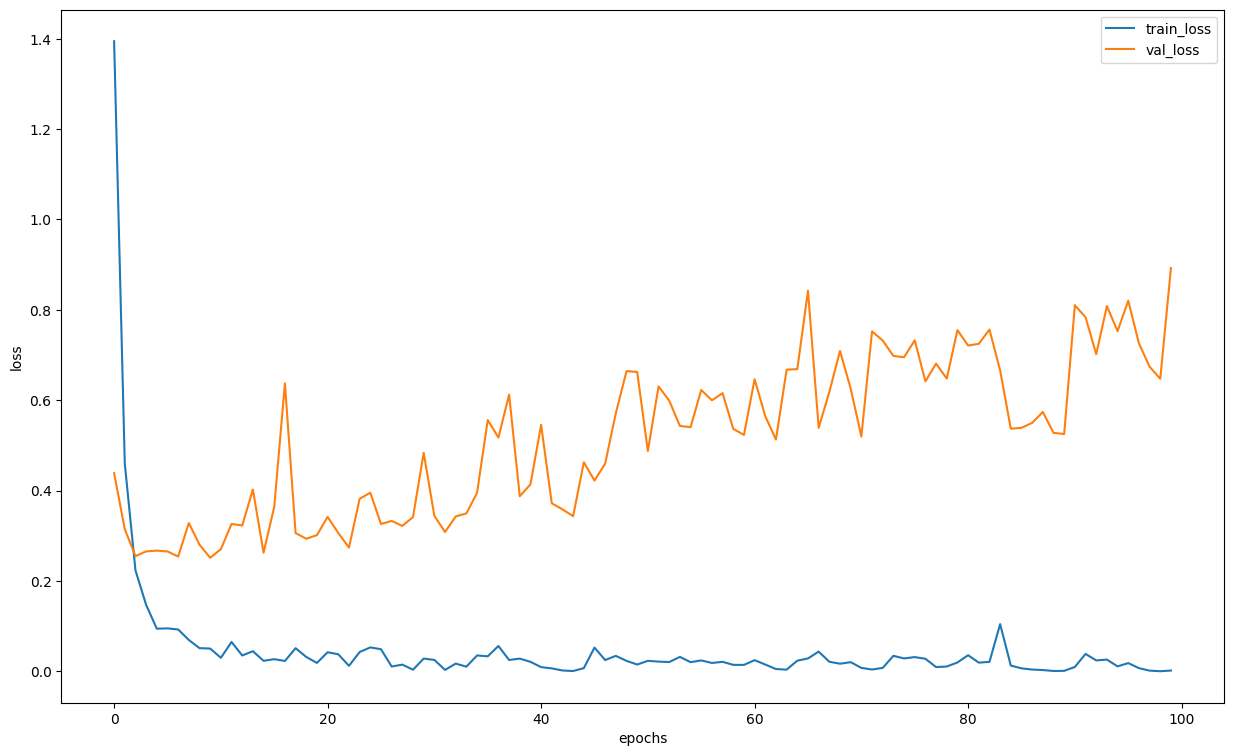

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

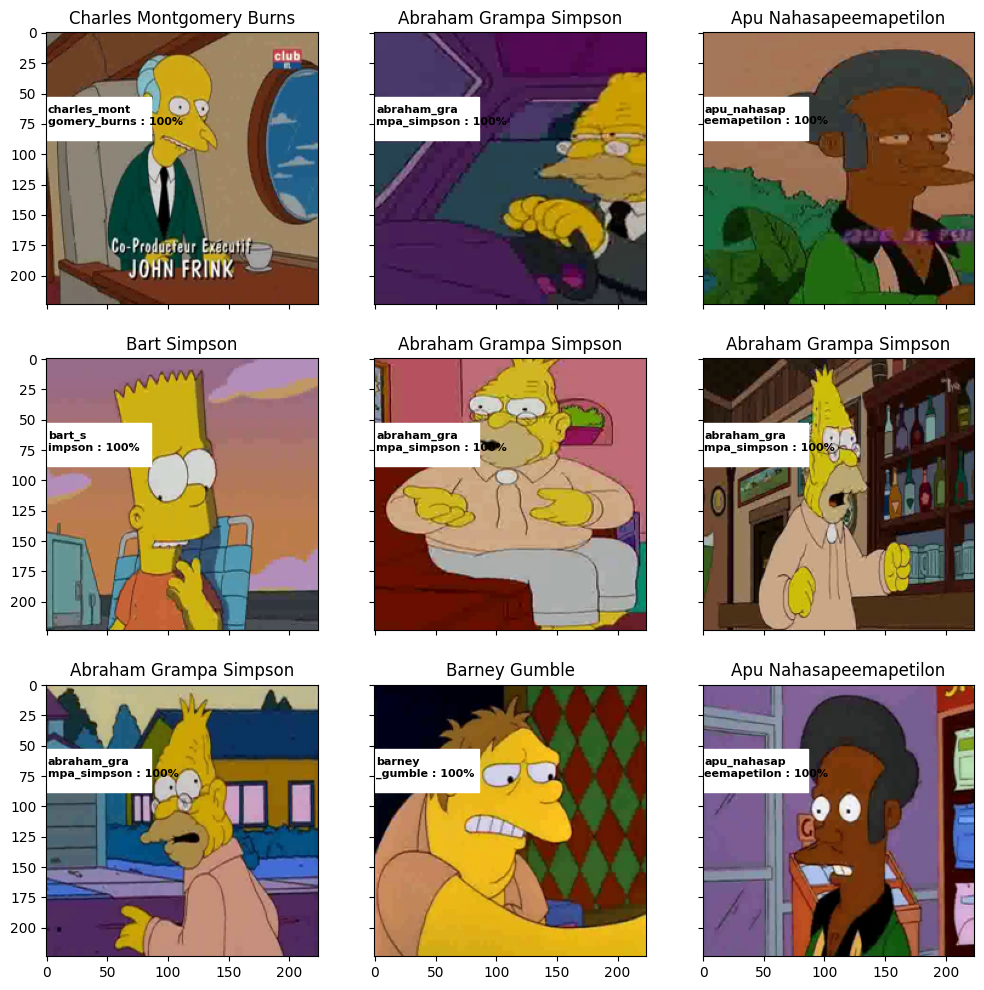

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  journey-springfield.zip  sample_data	     testset
drive			     label_encoder.pkl	      sample_submission.csv  train


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
